# Regression Deep Learning Model for Song Year Prediction Using TensorFlow Take 4
### David Lowe
### March 10, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a prediction model using various machine learning algorithms and to document the end-to-end steps using a template. The Song Year Prediction dataset is a classic regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: This data is a subset of the Million Song Dataset, http://labrosa.ee.columbia.edu/millionsong/, a collaboration between LabROSA (Columbia University) and The Echo Nest. The purpose of this exercise is to predict the release year of a song from audio features. Songs are mostly western, commercial tracks ranging from 1922 to 2011, with a peak in the year 2000s. The data preparer recommended the train/test split of the first 463,715 examples for training and the last 51,630 examples for testing. This approach avoids the 'producer effect' by making sure no song from a given artist ends up in both the train and test set.

In iteration Take1, we constructed several Multilayer Perceptron (MLP) models with one hidden layer of 16, 32, 64, and 128 nodes. The single-layer MLP model serves as the baseline model as we build more complex MLP models in future iterations.

In iteration Take2, we constructed several Multilayer Perceptron (MLP) models with two hidden layers. We also observed the effects of having the additional layer in our MLP models.

In iteration Take3, we constructed several Multilayer Perceptron (MLP) models with three hidden layers. We also observed whether the additional layers improved the RMSE as we build more complex MLP models in future iterations.

In this Take4 iteration, we will construct several Multilayer Perceptron (MLP) models with dropout. We will observe whether the additional dropout layers can improve the RMSE as we build more complex MLP models in future iterations.

ANALYSIS: In iteration Take1, all models processed the test dataset and produced RMSEs that are around 9.50. However, the single-layer models do not exhibit a stable curve when making predictions with the test dataset.

In iteration Take2, all models processed the test dataset and again produced RMSEs that are around 9.50. Moreover, the dual-layer models also did not exhibit a stable curve when making predictions with the test dataset.

In iteration Take3, all models processed the test dataset and again produced RMSEs that are around 9.50. Moreover, the three-layer models also did not exhibit a stable curve when making predictions with the test dataset.

In this Take4 iteration, the model with 256/128/64 layers and 0.2/0.2/0.0 dropout layers processed the test dataset and produced RMSEs that are around 8.90. Moreover, the multi-layer models with dropout on the first two hidden layers did a better job of having more stable training and testing curves.

CONCLUSION: For this iteration, the different model architectures with dropout produced a better RMSE compared to the models without the dropout layers. For this dataset, we should consider experimenting with more MLP models with some regularization techniques.

Dataset Used: YearPredictionMSD Dataset

Dataset ML Model: Regression with numerical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD

Thierry Bertin-Mahieux, Daniel P.W. Ellis, Brian Whitman, and Paul Lamere. The Million Song Dataset. In Proceedings of the 12th International Society for Music Information Retrieval Conference (ISMIR 2011), 2011.

One potential source of performance benchmarks: https://www.kaggle.com/uciml/msd-audio-features/home

Any deep-learning modeling project genrally can be broken down into about seven major tasks:

0. Prepare Environment
1. Load Data
2. Define Model
3. Fit and Evaluate Model
4. Optimize Model
5. Finalize Model

# Section 0. Prepare Environment

In [1]:
# Retrieve GPU information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Thu Mar  5 16:12:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
# Set the random seed number for reproducible results
seedNum = 888

In [0]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import matplotlib.pyplot as plt
from datetime import datetime
from email.message import EmailMessage
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing

In [5]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting to True will activate)
# verbose = True
# tf.debugging.set_log_device_placement(verbose)

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the number of folds for cross validation
n_folds = 5

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set various default Keras modeling parameters
default_loss = 'mean_squared_error'
default_optimizer = tf.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.initializers.GlorotNormal(seed=seedNum)
default_epoch = 50
default_batch = 32

Num GPUs Available:  1


In [0]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Keras Regression Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [0]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [0]:
if (notifyStatus): email_notify("Phase 0 Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 1. Load Data

In [0]:
if (notifyStatus): email_notify("Phase 1 Load Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 1.a) Load Dataset

In [10]:
dataset_path = 'https://dainesanalytics.com/datasets/ucirvine-year-prediction-msd/YearPredictionMSD.txt'
attrNames = ['attr' + str(i) for i in range(1,91)]
colNames = ['targetVar'] + attrNames
Xy_original = pd.read_csv(dataset_path, sep=',', names=colNames, header=None, index_col=False)

# Take a peek at the dataframe after the import
Xy_original.head(10)

,targetVar,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,attr10,attr11,attr12,attr13,attr14,attr15,attr16,attr17,attr18,attr19,attr20,attr21,attr22,attr23,attr24,attr25,attr26,attr27,attr28,attr29,attr30,attr31,attr32,attr33,attr34,attr35,attr36,attr37,attr38,attr39,...,attr51,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60,attr61,attr62,attr63,attr64,attr65,attr66,attr67,attr68,attr69,attr70,attr71,attr72,attr73,attr74,attr75,attr76,attr77,attr78,attr79,attr80,attr81,attr82,attr83,attr84,attr85,attr86,attr87,attr88,attr89,attr90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-3

In [11]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515345 entries, 0 to 515344
Data columns (total 91 columns):
targetVar    515345 non-null int64
attr1        515345 non-null float64
attr2        515345 non-null float64
attr3        515345 non-null float64
attr4        515345 non-null float64
attr5        515345 non-null float64
attr6        515345 non-null float64
attr7        515345 non-null float64
attr8        515345 non-null float64
attr9        515345 non-null float64
attr10       515345 non-null float64
attr11       515345 non-null float64
attr12       515345 non-null float64
attr13       515345 non-null float64
attr14       515345 non-null float64
attr15       515345 non-null float64
attr16       515345 non-null float64
attr17       515345 non-null float64
attr18       515345 non-null float64
attr19       515345 non-null float64
attr20       515345 non-null float64
attr21       515345 non-null float64
attr22       515345 non-null float64
attr23       515345 non-null float64
att

In [12]:
Xy_original.describe()

,targetVar,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,attr10,attr11,attr12,attr13,attr14,attr15,attr16,attr17,attr18,attr19,attr20,attr21,attr22,attr23,attr24,attr25,attr26,attr27,attr28,attr29,attr30,attr31,attr32,attr33,attr34,attr35,attr36,attr37,attr38,attr39,...,attr51,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60,attr61,attr62,attr63,attr64,attr65,attr66,attr67,attr68,attr69,attr70,attr71,attr72,attr73,attr74,attr75,attr76,attr77,attr78,attr79,attr80,attr81,attr82,attr83,attr84,attr85,attr86,attr87,attr88,attr89,attr90
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,1998.397082,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,1.882385,-0.146527,2.546063,33.714006,2439.359375,1967.734202,1514.859902,910.981344,879.146721,603.737434,517.579339,393.962215,325.733170,288.885085,291.973238,43.031969,43.314873,-46.449006,-27.672783,14.958491,44.514859,5.131786,24.034309,9.498816,-4.178856,0.499475,72.652267,-51.441256,117.921056,-189.880885,...,6.378511,28.294082,12.772241,1.700474,-10.205155,64.101262,104.822085,-0.026481,38.678040,-27.989985,3.301739,0.307127,-0.478828,-138.223224,-0.696065,0.242582,3.151751,27.642745,31.822244,-0.835950,-8.931564,4.849253,-27.347646,-11.938792,-21.572137,-5.576196,-23.304324,31.113053,-104.974794,26.962393,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105
std,10.931046,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,6.530232,4.370848,8.320190,22.259632,1749.367690,1261.484792,1092.831044,475.708203,576.865994,317.499288,309.364735,214.013502,165.699383,186.960729,153.475649,121.429498,715.759147,544.879865,218.368476,163.215789,134.887832,99.088119,71.809934,74.411680,53.517036,42.490396,107.912629,415.039100,453.399231,260.645370,...,93.555672,75.049277,69.981849,83.278660,57.806591,273.827189,311.135298,266.774027,169.072163,144.083035,59.447204,49.181425,37.675424,308.187390,222.198519,128.140961,99.920949,116.696176,106.359938,36.799193,251.606754,229.060421,163.782620,63.288891,64.691545,26.358175,268.190912,144.156203,201.137522,123.847891,32.099635,175.618889,122.228799,95.050631,16.161764,114.427905,173.977336,13.346557,185.558247,22.088576
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,-41.631660,-69.680870,-94.041960,0.132830,8.474200,21.214350,17.857900,12.150420,5.517710,19.808810,6.254870,6.183760,15.307500,6.116440,5.177340,-2821.430210,-13390.360690,-12017.088870,-4324.864700,-3357.279900,-3115.374560,-3805.666170,-1516.356440,-1679.118320,-1590.637130,-989.645800,-1711.484000,-8448.194880,-10095.725950,-9803.759040,...,-2270.811070,-1746.478220,-3188.177380,-2199.782210,-1694.260320,-5154.024360,-5111.601750,-4730.599100,-3756.490790,-2499.954680,-1900.104800,-1396.701680,-600.090760,-10

In [13]:
Xy_original.isnull().sum()

targetVar    0
attr1        0
attr2        0
attr3        0
attr4        0
            ..
attr86       0
attr87       0
attr88       0
attr89       0
attr90       0
Length: 91, dtype: int64

In [14]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


## 1.b) Data Cleaning

In [15]:
# Not applicable for this iteration of modeling

# Take a peek at the dataframe after the cleaning
Xy_original.head(10)

,targetVar,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,attr10,attr11,attr12,attr13,attr14,attr15,attr16,attr17,attr18,attr19,attr20,attr21,attr22,attr23,attr24,attr25,attr26,attr27,attr28,attr29,attr30,attr31,attr32,attr33,attr34,attr35,attr36,attr37,attr38,attr39,...,attr51,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60,attr61,attr62,attr63,attr64,attr65,attr66,attr67,attr68,attr69,attr70,attr71,attr72,attr73,attr74,attr75,attr76,attr77,attr78,attr79,attr80,attr81,attr82,attr83,attr84,attr85,attr86,attr87,attr88,attr89,attr90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-3

In [16]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515345 entries, 0 to 515344
Data columns (total 91 columns):
targetVar    515345 non-null int64
attr1        515345 non-null float64
attr2        515345 non-null float64
attr3        515345 non-null float64
attr4        515345 non-null float64
attr5        515345 non-null float64
attr6        515345 non-null float64
attr7        515345 non-null float64
attr8        515345 non-null float64
attr9        515345 non-null float64
attr10       515345 non-null float64
attr11       515345 non-null float64
attr12       515345 non-null float64
attr13       515345 non-null float64
attr14       515345 non-null float64
attr15       515345 non-null float64
attr16       515345 non-null float64
attr17       515345 non-null float64
attr18       515345 non-null float64
attr19       515345 non-null float64
attr20       515345 non-null float64
attr21       515345 non-null float64
attr22       515345 non-null float64
attr23       515345 non-null float64
att

In [17]:
Xy_original.describe()

,targetVar,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,attr10,attr11,attr12,attr13,attr14,attr15,attr16,attr17,attr18,attr19,attr20,attr21,attr22,attr23,attr24,attr25,attr26,attr27,attr28,attr29,attr30,attr31,attr32,attr33,attr34,attr35,attr36,attr37,attr38,attr39,...,attr51,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60,attr61,attr62,attr63,attr64,attr65,attr66,attr67,attr68,attr69,attr70,attr71,attr72,attr73,attr74,attr75,attr76,attr77,attr78,attr79,attr80,attr81,attr82,attr83,attr84,attr85,attr86,attr87,attr88,attr89,attr90
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,1998.397082,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,1.882385,-0.146527,2.546063,33.714006,2439.359375,1967.734202,1514.859902,910.981344,879.146721,603.737434,517.579339,393.962215,325.733170,288.885085,291.973238,43.031969,43.314873,-46.449006,-27.672783,14.958491,44.514859,5.131786,24.034309,9.498816,-4.178856,0.499475,72.652267,-51.441256,117.921056,-189.880885,...,6.378511,28.294082,12.772241,1.700474,-10.205155,64.101262,104.822085,-0.026481,38.678040,-27.989985,3.301739,0.307127,-0.478828,-138.223224,-0.696065,0.242582,3.151751,27.642745,31.822244,-0.835950,-8.931564,4.849253,-27.347646,-11.938792,-21.572137,-5.576196,-23.304324,31.113053,-104.974794,26.962393,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105
std,10.931046,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,6.530232,4.370848,8.320190,22.259632,1749.367690,1261.484792,1092.831044,475.708203,576.865994,317.499288,309.364735,214.013502,165.699383,186.960729,153.475649,121.429498,715.759147,544.879865,218.368476,163.215789,134.887832,99.088119,71.809934,74.411680,53.517036,42.490396,107.912629,415.039100,453.399231,260.645370,...,93.555672,75.049277,69.981849,83.278660,57.806591,273.827189,311.135298,266.774027,169.072163,144.083035,59.447204,49.181425,37.675424,308.187390,222.198519,128.140961,99.920949,116.696176,106.359938,36.799193,251.606754,229.060421,163.782620,63.288891,64.691545,26.358175,268.190912,144.156203,201.137522,123.847891,32.099635,175.618889,122.228799,95.050631,16.161764,114.427905,173.977336,13.346557,185.558247,22.088576
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,-41.631660,-69.680870,-94.041960,0.132830,8.474200,21.214350,17.857900,12.150420,5.517710,19.808810,6.254870,6.183760,15.307500,6.116440,5.177340,-2821.430210,-13390.360690,-12017.088870,-4324.864700,-3357.279900,-3115.374560,-3805.666170,-1516.356440,-1679.118320,-1590.637130,-989.645800,-1711.484000,-8448.194880,-10095.725950,-9803.759040,...,-2270.811070,-1746.478220,-3188.177380,-2199.782210,-1694.260320,-5154.024360,-5111.601750,-4730.599100,-3756.490790,-2499.954680,-1900.104800,-1396.701680,-600.090760,-10

In [18]:
Xy_original.isnull().sum()

targetVar    0
attr1        0
attr2        0
attr3        0
attr4        0
            ..
attr86       0
attr87       0
attr88       0
attr89       0
attr90       0
Length: 91, dtype: int64

In [19]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


## 1.c) Feature Scaling and Pre-processing

In [0]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = 1

In [21]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (515345, 91) X_original.shape: (515345, 90) y_original.shape: (515345,)


In [0]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

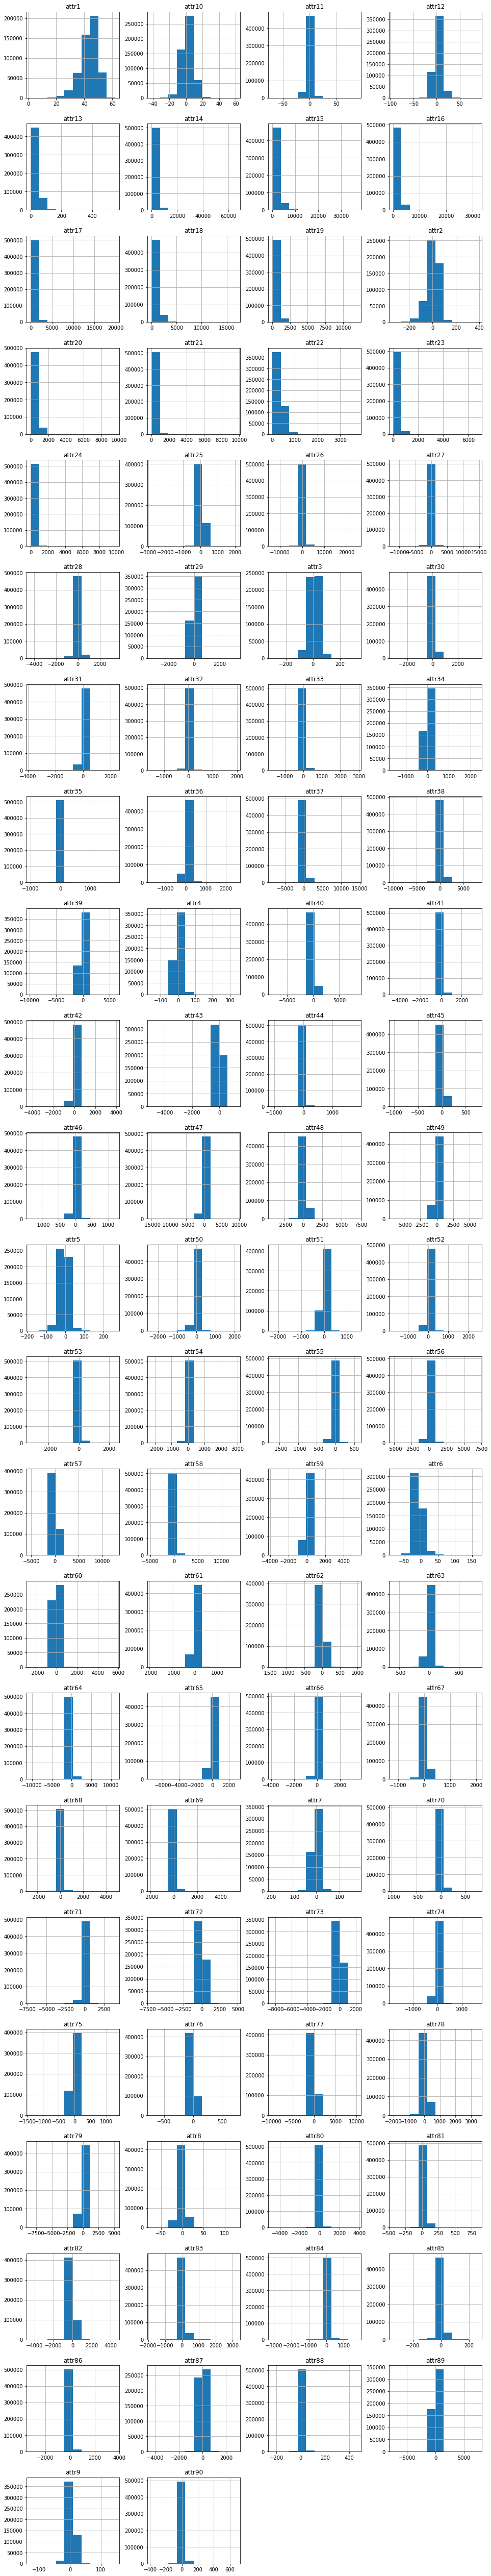

In [23]:
# Histograms for each attribute before pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

In [24]:
tobe_transformed_cols = X_original.columns.tolist()
# tobe_transformed_cols.remove('some_column_label')
print(tobe_transformed_cols)

['attr1', 'attr2', 'attr3', 'attr4', 'attr5', 'attr6', 'attr7', 'attr8', 'attr9', 'attr10', 'attr11', 'attr12', 'attr13', 'attr14', 'attr15', 'attr16', 'attr17', 'attr18', 'attr19', 'attr20', 'attr21', 'attr22', 'attr23', 'attr24', 'attr25', 'attr26', 'attr27', 'attr28', 'attr29', 'attr30', 'attr31', 'attr32', 'attr33', 'attr34', 'attr35', 'attr36', 'attr37', 'attr38', 'attr39', 'attr40', 'attr41', 'attr42', 'attr43', 'attr44', 'attr45', 'attr46', 'attr47', 'attr48', 'attr49', 'attr50', 'attr51', 'attr52', 'attr53', 'attr54', 'attr55', 'attr56', 'attr57', 'attr58', 'attr59', 'attr60', 'attr61', 'attr62', 'attr63', 'attr64', 'attr65', 'attr66', 'attr67', 'attr68', 'attr69', 'attr70', 'attr71', 'attr72', 'attr73', 'attr74', 'attr75', 'attr76', 'attr77', 'attr78', 'attr79', 'attr80', 'attr81', 'attr82', 'attr83', 'attr84', 'attr85', 'attr86', 'attr87', 'attr88', 'attr89', 'attr90']


In [25]:
# Apply feature scaling and transformation
X_original = X_original.astype(float)
scaler = preprocessing.StandardScaler()
X_original[tobe_transformed_cols] = scaler.fit_transform(X_original[tobe_transformed_cols])

X_original.head(-10)

,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,attr10,attr11,attr12,attr13,attr14,attr15,attr16,attr17,attr18,attr19,attr20,attr21,attr22,attr23,attr24,attr25,attr26,attr27,attr28,attr29,attr30,attr31,attr32,attr33,attr34,attr35,attr36,attr37,attr38,attr39,attr40,...,attr51,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60,attr61,attr62,attr63,attr64,attr65,attr66,attr67,attr68,attr69,attr70,attr71,attr72,attr73,attr74,attr75,attr76,attr77,attr78,attr79,attr80,attr81,attr82,attr83,attr84,attr85,attr86,attr87,attr88,attr89,attr90
0,1.080575,0.391265,1.826532,0.464657,-0.474730,-0.278204,-1.552371,-1.310845,0.387704,-0.666166,0.793414,-0.584275,-1.056103,-1.045093,-0.805912,-0.747368,-1.055262,-0.858844,-0.873144,-0.903356,-0.666024,-0.836212,-1.008012,-0.734829,-0.423683,-0.504619,0.261180,0.347007,-0.677763,-0.463919,-0.031910,0.144689,0.029940,0.103645,0.171685,-0.676680,-0.198144,-0.443721,0.585406,0.242786,...,-0.339481,-0.429076,0.007435,0.478516,0.050901,-0.310816,0.002206,0.241122,-0.074484,-0.115219,-0.195271,0.155139,-0.272267,0.138797,-0.366056,-0.279650,0.015447,0.371165,-0.035078,0.186311,-0.112104,-0.200706,0.115638,0.302385,0.200496,-0.012610,0.040941,-0.113944,0.251836,0.106465,-0.085335,0.108508,0.142775,-0.237355,0.049233,-0.356182,0.544458,-0.470599,-0.255977,0.042292
1,0.880919,0.332292,1.748539,0.721828,-0.164945,-1.191173,0.765681,0.109626,1.420941,0.414950,0.541252,-0.265139,0.479611,-0.218605,-1.079941,-0.967624,-0.281324,-0.803477,0.449577,-0.488505,-0.355738,-0.317769,-0.786935,0.165365,-0.193934,-0.151685,0.383939,0.744982,-0.681570,-0.974102,0.123618,0.304598,0.309095,-0.535819,1.049858,-0.424444,-0.605081,-0.352097,0.195786,0.870474,...,0.236999,-0.356714,0.831972,-0.544332,-0.559539,0.240032,-0.079926,-0.326565,-0.499388,-0.262564,-0.794017,-0.401863,0.346923,-0.874203,0.196257,0.092991,-0.916031,0.125195,0.137927,-0.797342,0.218263,0.548457,0.251739,0.125429,0.609536,-0.483539,-0.241197,-0.116109,0.409042,-0.692585,-0.314250,0.306236,-0.069483,0.052017,-0.632328,-0.436057,0.556448,0.568744,0.206940,1.158587
2,1.247622,0.592600,1.337173,0.750657,-0.001110,-0.702100,-0.060914,-0.069956,1.166254,-0.074608,0.659382,-0.206489,-1.179183,-0.994540,-0.754449,-0.842576,-1.167197,-0.644427,-0.680438,-0.744836,-1.315763,-0.990010,-0.774182,-0.603851,-0.389326,-0.475469,-0.187041,0.090331,-0.206321,-0.235303,-0.307898,-0.199418,-0.125792,0.578809,0.136693,-0.407285,-0.056498,-0.897922,0.090621,-0.048620,...,0.129665,-0.150860,0.164243,-0.146597,0.026313,-0.034123,0.289001,0.029936,-0.336572,0.194712,-0.099793,0.522931,0.059352,-0.402827,-1.048185,-0.021442,-0.153067,0.460456,-0.279680,-0.026845,0.765419,0.077703,-0.077183,0.873971,-0.154506,0.026094,-0.049322,-0.381945,0.103323,0.315248,-0.396186,0.566683,-0.756534,-0.284019,-0.024220,0.223128,-0.509789,-0.338457,0.105819,-0.090208
3,0.801044,-0.061805,0.783683,0.087218,0.329180,-1.298429,0.510714,-1.073355,-0.016803,-1.262655,1.550430,-0.708817,0.176411,-0.151642,-1.006990,-0.965945,-0.353561,-1.126500,-0.679815,-0.867950,-0.691843,-0.902406,-1.016593,-0.918716,0.292010,-0.147141,0.165074,-0.314855,-0.759269,-0.224530,0.094966,-0.662728,-0.656730,-0.736462,0.478642,-0.342991,-0.313003,-0.466669,0.381073,-0.112344,...,-0.019340,-0.874318,-0.123184,0.126595,0.782474,-0.887411,-0.071854,-0.076723,0.373259,0.056994,-0.417653,0.062135,-0.296027,0.615786,-0.224483,-0.221554,-0.863781,-0.299885,-0.507121,0.054858,-0.452187,0.636184,0.315799,0.839595,-0.239151,-0.878425,0.691674,-0.061946,0.478975,0.470511,0.586237,-0.559427,-0.478689,-0.890161,-0.793906,0.567269,-0.263107,0.408116,0.967862,0.793384
4,1.249775,0.793334,1.657037,0.447460,-0.406775,-0.567138,-0.692498,-0.952197,0.841844,-0.144910,0.401697,-0.042527,0.611278,-0.883220,-0.917862,-1.094474,-1.000481,-0.931815,-0.848601,-0.628978,-0.950142,-0.542465,-1.026901,-0.530277,-0.308223,-0.339436,0.461216,-0.226700,-0.494780,-0.381546,-0.174435,-0.388365,0.150394,-0.301324,0.862572,-0.569401,-

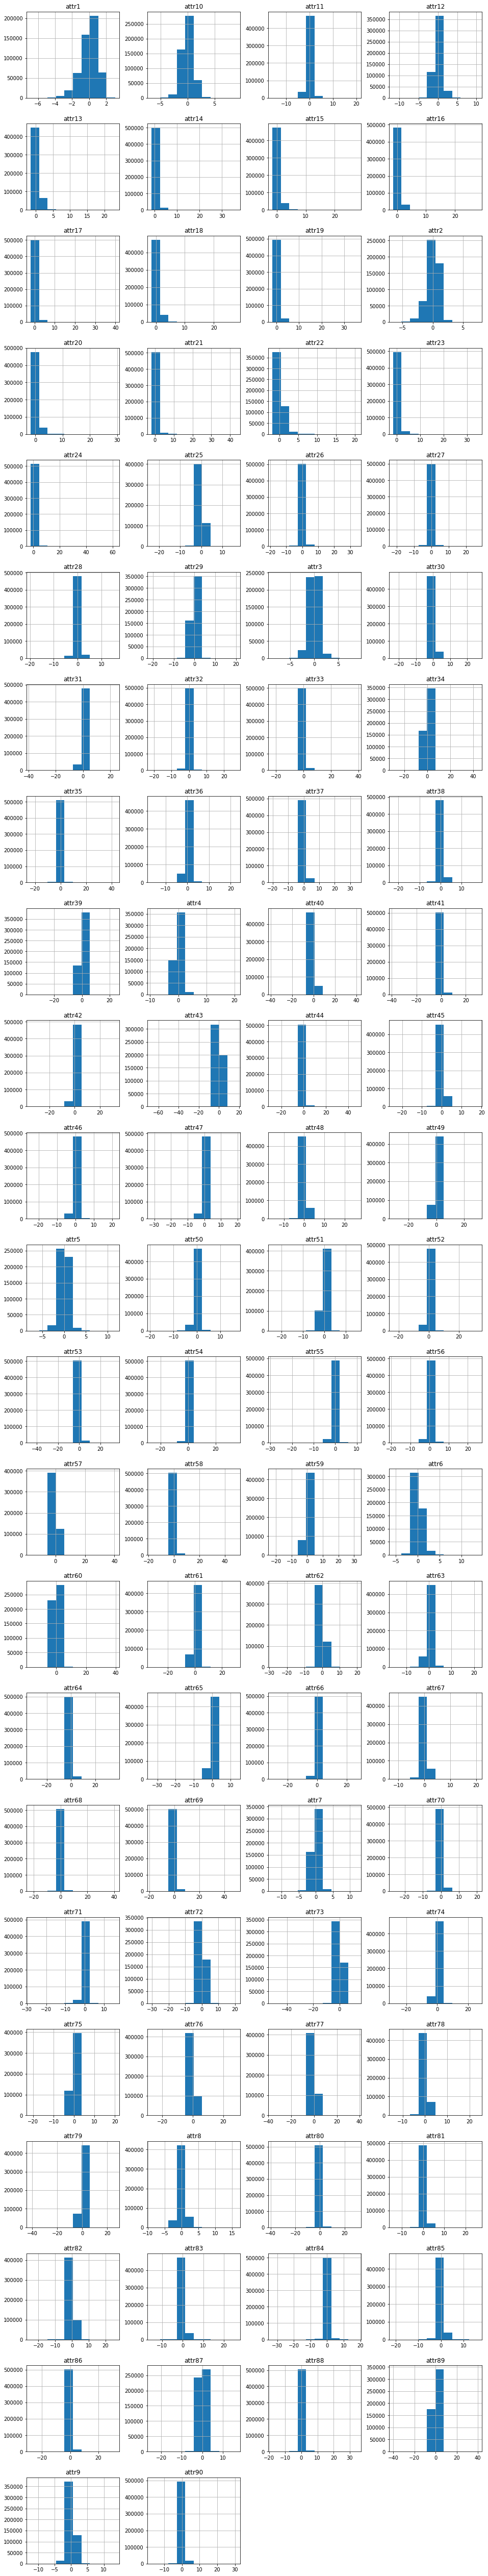

In [26]:
# Histograms for each attribute after pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

## 1.d) Splitting Data into Training and Test Sets

In [0]:
# Perform one-hot-encoding before splitting into trainig and test
# X_original = pd.get_dummies(X_original)
# print(X_original.info())

In [28]:
X_encoded = X_original.to_numpy()
y_encoded = y_original.to_numpy()
# if (splitDataset):
#     X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=splitPercentage, random_state=seedNum)
# else:
#     X_train, y_train = X_encoded, y_encoded
#     X_test, y_test = X_encoded, y_encoded

split_point = 463715
X_train = X_encoded[:split_point]
y_train = y_encoded[:split_point]
X_test = X_encoded[split_point:]
y_test = y_encoded[split_point:]
print("X_train.shape: {} X_train.type: {}".format(X_train.shape, type(X_train)))
print("y_train.shape: {} y_train.type: {}".format(y_train.shape, type(y_train)))
print("X_test.shape: {} X_test.type: {}".format(X_test.shape, type(X_test)))
print("y_test.shape: {} y_test.type: {}".format(y_test.shape, type(y_test)))

X_train.shape: (463715, 90) X_train.type: <class 'numpy.ndarray'>
y_train.shape: (463715,) y_train.type: <class 'numpy.ndarray'>
X_test.shape: (51630, 90) X_test.type: <class 'numpy.ndarray'>
y_test.shape: (51630,) y_test.type: <class 'numpy.ndarray'>


In [0]:
if (notifyStatus): email_notify("Phase 1 Load Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 2. Define Model

In [0]:
if (notifyStatus): email_notify("Phase 2 Define Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [0]:
# Not applicable for this iteration of modeling

In [0]:
if (notifyStatus): email_notify("Phase 2 Define Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 3. Fit and Evaluate Model

In [0]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [0]:
# Not applicable for this iteration of modeling

In [0]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 4. Explore Different Three-Layer Models with Dropout

In [0]:
if (notifyStatus): email_notify("Phase 4 Explore Different One-Layer Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 39s 84us/sample - loss: 121115.2893 - val_loss: 1028.2421
Epoch 2/50
463715/463715 [==============================] - 38s 82us/sample - loss: 3134.0158 - val_loss: 2422.9125
Epoch 3/50
463715/463715 [==============================] - 38s 81us/sample - loss: 243.6888 - val_loss: 136.4176
Epoch 4/50
463715/463715 [==============================] - 37s 79us/sample - loss: 98.9485 - val_loss: 86.7724
Epoch 5/50
463715/463715 [==============================] - 37s 79us/sample - loss: 89.0485 - val_loss: 82.9530
Epoch 6/50
463715/463715 [==============================] - 36s 78us/sample - loss: 84.4314 - val_loss: 80.9837
Epoch 7/50
463715/463715 [==============================] - 36s 78us/sample - loss: 83.2509 - val_loss: 80.2307
Epoch 8/50
463715/463715 [==============================] - 36s 78us/sample - loss: 82.8834 - val_loss: 80.8834
Epoch 9/50
463715/463715 [===============

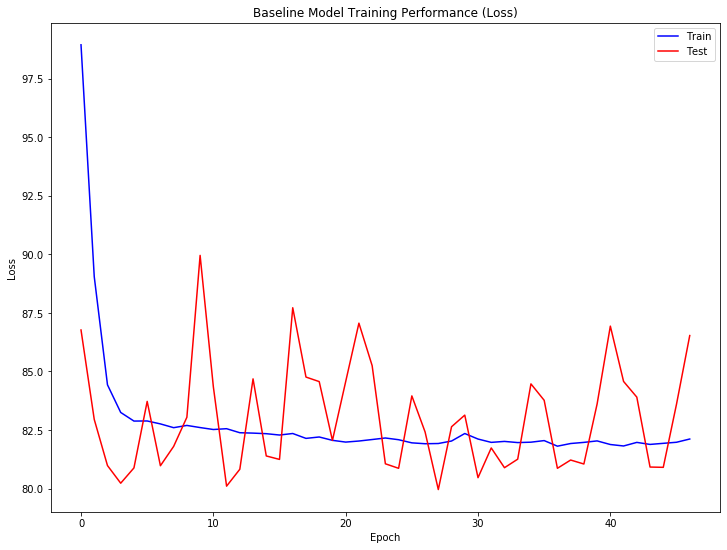

In [0]:
# Define MLP model #4B_1
def create_model_4B_1():
    default_model = Sequential()
    default_model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.1))
    default_model.add(Dense(16, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(8, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4B_1 = create_model_4B_1()
extra_epochs = 0
baseline_hist = baseline_model_4B_1.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 3
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 36s 78us/sample - loss: 66579.9707 - val_loss: 33273.9483
Epoch 2/50
463715/463715 [==============================] - 36s 78us/sample - loss: 2778.1431 - val_loss: 39817.0339
Epoch 3/50
463715/463715 [==============================] - 36s 77us/sample - loss: 663.5090 - val_loss: 35244.0673
Epoch 4/50
463715/463715 [==============================] - 36s 78us/sample - loss: 482.1186 - val_loss: 36807.0295
Epoch 5/50
463715/463715 [==============================] - 36s 78us/sample - loss: 425.2269 - val_loss: 36309.4965
Epoch 6/50
463715/463715 [==============================] - 35s 76us/sample - loss: 393.2724 - val_loss: 35386.1045
Epoch 7/50
463715/463715 [==============================] - 36s 77us/sample - loss: 356.3070 - val_loss: 38246.1482
Epoch 8/50
463715/463715 [==============================] - 36s 77us/sample - loss: 326.1658 - val_loss: 38443.6856
Epoch 9/50
463715/

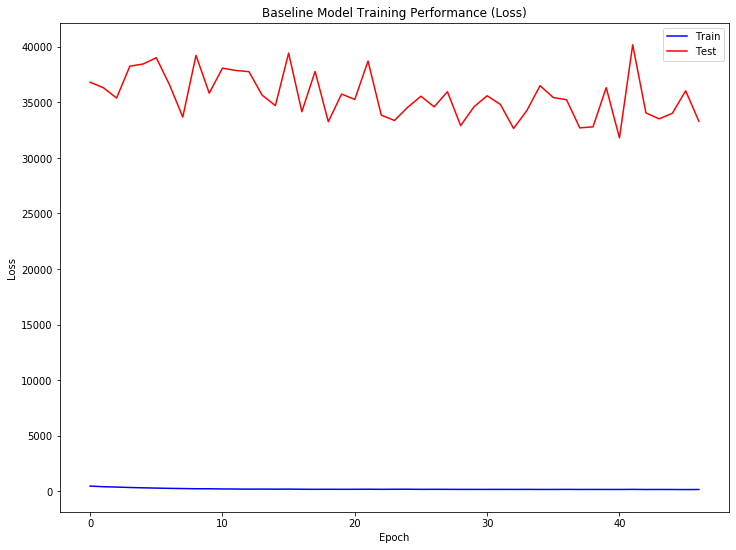

In [0]:
# Define MLP model #4B_2
def create_model_4B_2():
    default_model = Sequential()
    default_model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(16, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.1))
    default_model.add(Dense(8, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4B_2 = create_model_4B_2()
extra_epochs = 0
baseline_hist = baseline_model_4B_2.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 3
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 37s 79us/sample - loss: 80815.0194 - val_loss: 22579.6556
Epoch 2/50
463715/463715 [==============================] - 37s 80us/sample - loss: 12229.7217 - val_loss: 39686.3699
Epoch 3/50
463715/463715 [==============================] - 36s 78us/sample - loss: 3528.1772 - val_loss: 38049.9210
Epoch 4/50
463715/463715 [==============================] - 37s 79us/sample - loss: 1667.3835 - val_loss: 31557.8295
Epoch 5/50
463715/463715 [==============================] - 36s 78us/sample - loss: 1418.5411 - val_loss: 28110.7565
Epoch 6/50
463715/463715 [==============================] - 37s 80us/sample - loss: 1194.5591 - val_loss: 27751.8823
Epoch 7/50
463715/463715 [==============================] - 37s 79us/sample - loss: 1120.5678 - val_loss: 28880.8923
Epoch 8/50
463715/463715 [==============================] - 36s 78us/sample - loss: 1073.6460 - val_loss: 27378.4933
Epoch 9/50


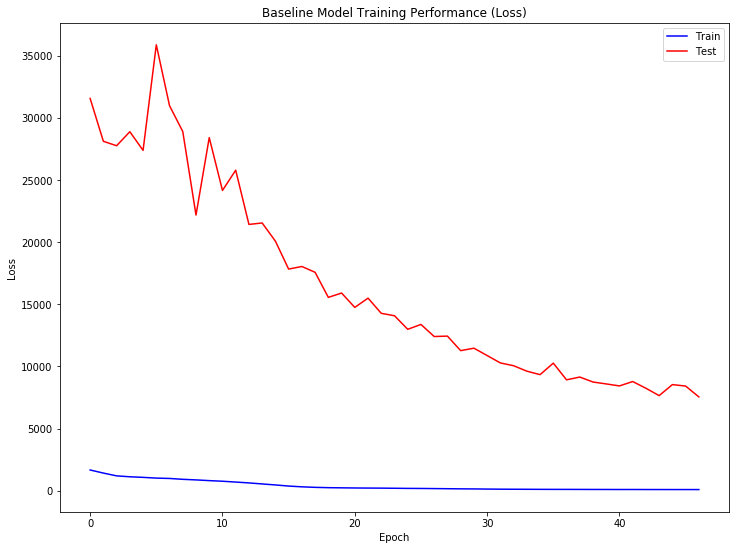

In [0]:
# Define MLP model #4B_3
def create_model_4B_3():
    default_model = Sequential()
    default_model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.1))
    default_model.add(Dense(16, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.1))
    default_model.add(Dense(8, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4B_3 = create_model_4B_3()
extra_epochs = 0
baseline_hist = baseline_model_4B_3.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 3
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 61s 132us/sample - loss: 78329.3309 - val_loss: 930.6641
Epoch 2/50
463715/463715 [==============================] - 59s 128us/sample - loss: 1835.5045 - val_loss: 223.4295
Epoch 3/50
463715/463715 [==============================] - 59s 126us/sample - loss: 111.5832 - val_loss: 186.9050
Epoch 4/50
463715/463715 [==============================] - 58s 125us/sample - loss: 96.0621 - val_loss: 86.8091
Epoch 5/50
463715/463715 [==============================] - 58s 125us/sample - loss: 89.3906 - val_loss: 82.6888
Epoch 6/50
463715/463715 [==============================] - 58s 124us/sample - loss: 87.7470 - val_loss: 81.8828
Epoch 7/50
463715/463715 [==============================] - 58s 125us/sample - loss: 87.2164 - val_loss: 82.1783
Epoch 8/50
463715/463715 [==============================] - 57s 123us/sample - loss: 86.4580 - val_loss: 97.4001
Epoch 9/50
463715/463715 [==========

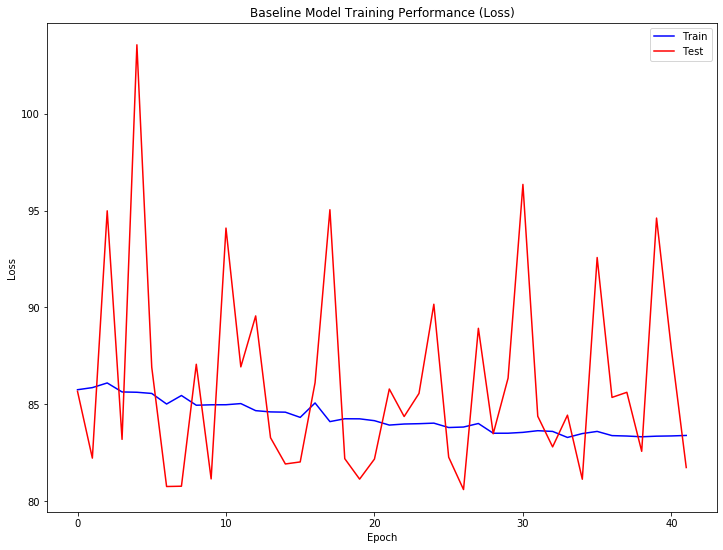

In [0]:
# Define MLP model #4C_1
def create_model_4C_1():
    default_model = Sequential()
    default_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.1))
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(16, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4C_1 = create_model_4C_1()
extra_epochs = 0
baseline_hist = baseline_model_4C_1.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 8
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 56s 120us/sample - loss: 44927.1155 - val_loss: 983.7328
Epoch 2/50
463715/463715 [==============================] - 57s 122us/sample - loss: 17270.9983 - val_loss: 1048.0111
Epoch 3/50
463715/463715 [==============================] - 56s 120us/sample - loss: 16558.4321 - val_loss: 772.8159
Epoch 4/50
463715/463715 [==============================] - 56s 120us/sample - loss: 15265.9360 - val_loss: 638.0728
Epoch 5/50
463715/463715 [==============================] - 56s 121us/sample - loss: 13431.0599 - val_loss: 620.7604
Epoch 6/50
463715/463715 [==============================] - 56s 121us/sample - loss: 10185.3017 - val_loss: 388.5160
Epoch 7/50
463715/463715 [==============================] - 57s 122us/sample - loss: 5098.9577 - val_loss: 324.2616
Epoch 8/50
463715/463715 [==============================] - 58s 124us/sample - loss: 727.1450 - val_loss: 82.5201
Epoch 9/50
46371

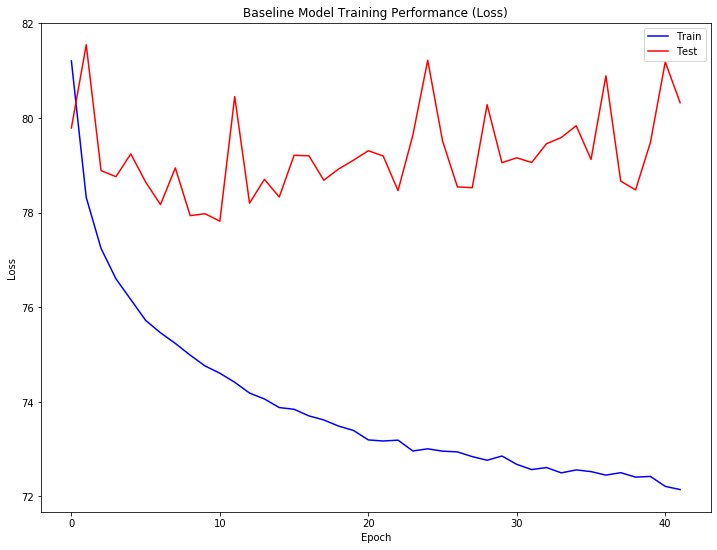

In [0]:
# Define MLP model #4C_2
def create_model_4C_2():
    default_model = Sequential()
    default_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.1))
    default_model.add(Dense(16, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4C_2 = create_model_4C_2()
extra_epochs = 0
baseline_hist = baseline_model_4C_2.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 8
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 59s 128us/sample - loss: 52265.9297 - val_loss: 1268.6065
Epoch 2/50
463715/463715 [==============================] - 60s 129us/sample - loss: 20189.4798 - val_loss: 1882.8633
Epoch 3/50
463715/463715 [==============================] - 59s 128us/sample - loss: 15190.3602 - val_loss: 231.2755
Epoch 4/50
463715/463715 [==============================] - 60s 130us/sample - loss: 12471.5784 - val_loss: 163.0639
Epoch 5/50
463715/463715 [==============================] - 59s 128us/sample - loss: 10261.3739 - val_loss: 351.1343
Epoch 6/50
463715/463715 [==============================] - 60s 130us/sample - loss: 6899.5428 - val_loss: 729.6357
Epoch 7/50
463715/463715 [==============================] - 60s 130us/sample - loss: 2326.3647 - val_loss: 95.3791
Epoch 8/50
463715/463715 [==============================] - 60s 130us/sample - loss: 152.4903 - val_loss: 81.8374
Epoch 9/50
463715

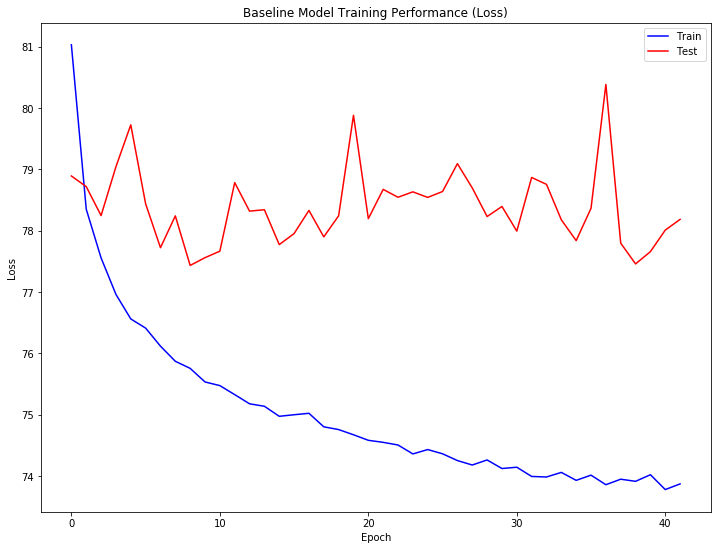

In [0]:
# Define MLP model #4C_3
def create_model_4C_3():
    default_model = Sequential()
    default_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.1))
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.1))
    default_model.add(Dense(16, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4C_3 = create_model_4C_3()
extra_epochs = 0
baseline_hist = baseline_model_4C_3.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 8
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 60s 129us/sample - loss: 41913.8125 - val_loss: 592.2118
Epoch 2/50
463715/463715 [==============================] - 58s 126us/sample - loss: 184.0225 - val_loss: 89.5329
Epoch 3/50
463715/463715 [==============================] - 58s 126us/sample - loss: 100.9558 - val_loss: 130.5830
Epoch 4/50
463715/463715 [==============================] - 59s 126us/sample - loss: 89.3453 - val_loss: 83.4300
Epoch 5/50
463715/463715 [==============================] - 59s 127us/sample - loss: 86.5608 - val_loss: 85.4422
Epoch 6/50
463715/463715 [==============================] - 58s 125us/sample - loss: 86.2596 - val_loss: 82.9119
Epoch 7/50
463715/463715 [==============================] - 58s 125us/sample - loss: 85.9599 - val_loss: 88.3201
Epoch 8/50
463715/463715 [==============================] - 58s 125us/sample - loss: 85.9383 - val_loss: 81.6670
Epoch 9/50
463715/463715 [============

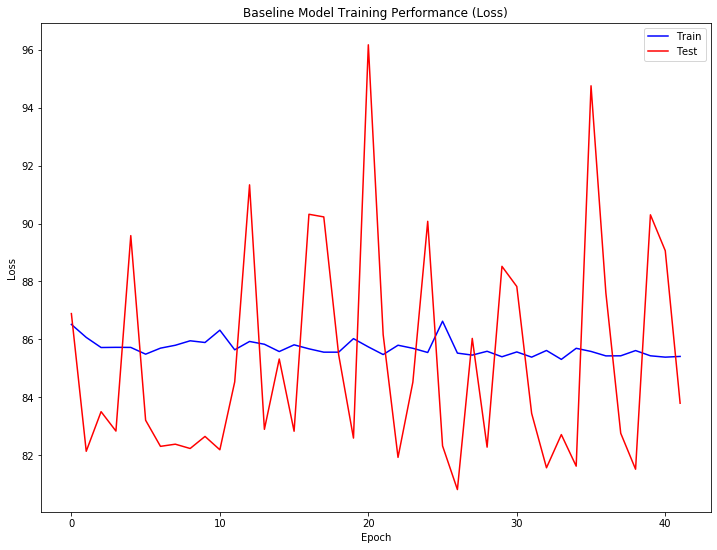

In [0]:
# Define MLP model #4C_4
def create_model_4C_4():
    default_model = Sequential()
    default_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.2))
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(16, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4C_4 = create_model_4C_4()
extra_epochs = 0
baseline_hist = baseline_model_4C_4.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 8
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 56s 120us/sample - loss: 47993.0751 - val_loss: 151059.9617
Epoch 2/50
463715/463715 [==============================] - 56s 120us/sample - loss: 5205.8442 - val_loss: 151877.7468
Epoch 3/50
463715/463715 [==============================] - 55s 118us/sample - loss: 1232.6847 - val_loss: 149477.8520
Epoch 4/50
463715/463715 [==============================] - 56s 121us/sample - loss: 843.9874 - val_loss: 148649.0794
Epoch 5/50
463715/463715 [==============================] - 56s 121us/sample - loss: 634.8740 - val_loss: 142220.0796
Epoch 6/50
463715/463715 [==============================] - 57s 122us/sample - loss: 509.1225 - val_loss: 136008.1244
Epoch 7/50
463715/463715 [==============================] - 57s 123us/sample - loss: 462.1390 - val_loss: 138715.2819
Epoch 8/50
463715/463715 [==============================] - 57s 123us/sample - loss: 452.9919 - val_loss: 147976.9334
E

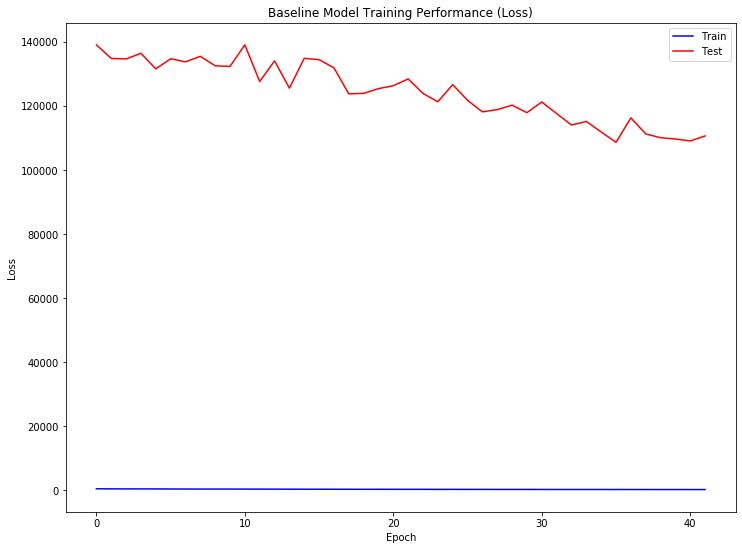

In [0]:
# Define MLP model #4C_5
def create_model_4C_5():
    default_model = Sequential()
    default_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.2))
    default_model.add(Dense(16, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4C_5 = create_model_4C_5()
extra_epochs = 0
baseline_hist = baseline_model_4C_5.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 8
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 61s 132us/sample - loss: 65092.5901 - val_loss: 102772.1078
Epoch 2/50
463715/463715 [==============================] - 62s 134us/sample - loss: 8022.0357 - val_loss: 133881.3323
Epoch 3/50
463715/463715 [==============================] - 59s 127us/sample - loss: 3307.2645 - val_loss: 116241.0970
Epoch 4/50
463715/463715 [==============================] - 59s 126us/sample - loss: 2858.0447 - val_loss: 137088.7970
Epoch 5/50
463715/463715 [==============================] - 59s 128us/sample - loss: 2539.4949 - val_loss: 118060.8328
Epoch 6/50
463715/463715 [==============================] - 60s 129us/sample - loss: 2256.5134 - val_loss: 105855.8283
Epoch 7/50
463715/463715 [==============================] - 60s 129us/sample - loss: 2059.8279 - val_loss: 114763.6715
Epoch 8/50
463715/463715 [==============================] - 60s 128us/sample - loss: 1966.3963 - val_loss: 108457.8

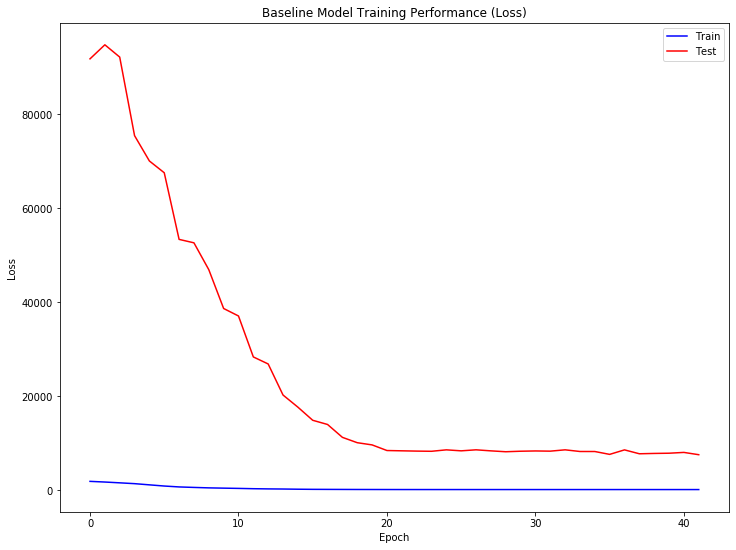

In [0]:
# Define MLP model #4C_6
def create_model_4C_6():
    default_model = Sequential()
    default_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.2))
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.2))
    default_model.add(Dense(16, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4C_6 = create_model_4C_6()
extra_epochs = 0
baseline_hist = baseline_model_4C_6.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 8
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 36s 79us/sample - loss: 23566.4633 - val_loss: 570.4556
Epoch 2/50
463715/463715 [==============================] - 36s 77us/sample - loss: 2592.1439 - val_loss: 134.4975
Epoch 3/50
463715/463715 [==============================] - 36s 77us/sample - loss: 218.9585 - val_loss: 373.3541
Epoch 4/50
463715/463715 [==============================] - 36s 77us/sample - loss: 114.8667 - val_loss: 94.6339
Epoch 5/50
463715/463715 [==============================] - 36s 77us/sample - loss: 92.8631 - val_loss: 84.5756
Epoch 6/50
463715/463715 [==============================] - 36s 77us/sample - loss: 88.6953 - val_loss: 83.8288
Epoch 7/50
463715/463715 [==============================] - 36s 78us/sample - loss: 87.0446 - val_loss: 82.2889
Epoch 8/50
463715/463715 [==============================] - 36s 77us/sample - loss: 87.5321 - val_loss: 86.9934
Epoch 9/50
463715/463715 [=================

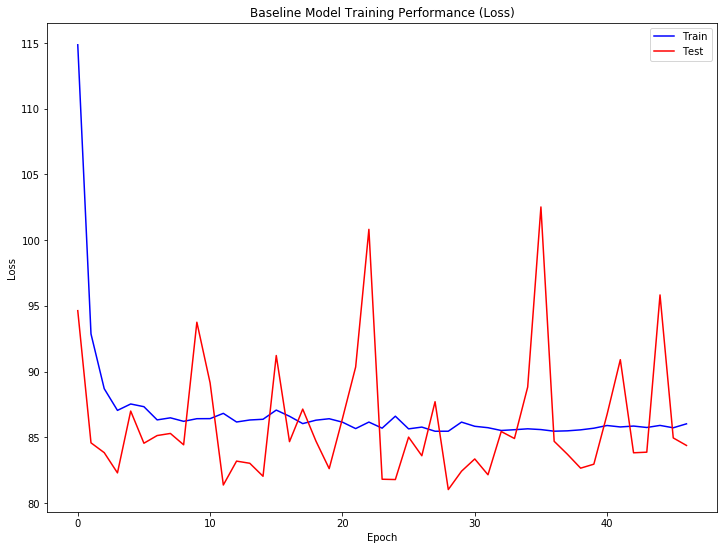

In [0]:
# Define MLP model #4D_1
def create_model_4D_1():
    default_model = Sequential()
    default_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.1))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4D_1 = create_model_4D_1()
extra_epochs = 0
baseline_hist = baseline_model_4D_1.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 3
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 37s 79us/sample - loss: 26837.5382 - val_loss: 26480.3404
Epoch 2/50
463715/463715 [==============================] - 36s 78us/sample - loss: 2137.3835 - val_loss: 34892.8022
Epoch 3/50
463715/463715 [==============================] - 36s 78us/sample - loss: 785.6884 - val_loss: 36853.7423
Epoch 4/50
463715/463715 [==============================] - 36s 77us/sample - loss: 429.4536 - val_loss: 38319.4393
Epoch 5/50
463715/463715 [==============================] - 36s 78us/sample - loss: 389.5551 - val_loss: 39079.4724
Epoch 6/50
463715/463715 [==============================] - 36s 78us/sample - loss: 388.6534 - val_loss: 38520.7212
Epoch 7/50
463715/463715 [==============================] - 36s 77us/sample - loss: 363.3566 - val_loss: 35721.7230
Epoch 8/50
463715/463715 [==============================] - 36s 77us/sample - loss: 367.9940 - val_loss: 41104.8943
Epoch 9/50
463715/

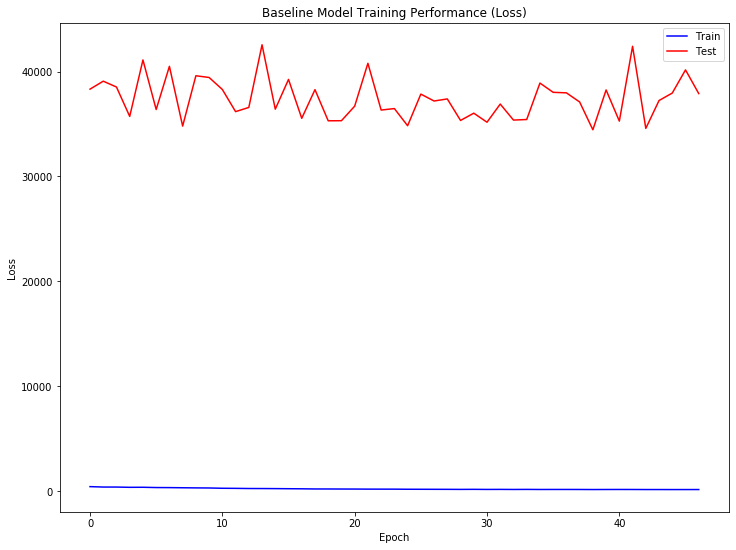

In [0]:
# Define MLP model #4D_2
def create_model_4D_2():
    default_model = Sequential()
    default_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.1))
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4D_2 = create_model_4D_2()
extra_epochs = 0
baseline_hist = baseline_model_4D_2.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 3
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 55s 118us/sample - loss: 34833.3215 - val_loss: 959.9332
Epoch 2/50
463715/463715 [==============================] - 55s 118us/sample - loss: 14004.8411 - val_loss: 1035.0775
Epoch 3/50
463715/463715 [==============================] - 54s 117us/sample - loss: 11900.4266 - val_loss: 542.3544
Epoch 4/50
463715/463715 [==============================] - 55s 119us/sample - loss: 8901.9267 - val_loss: 1895.7882
Epoch 5/50
463715/463715 [==============================] - 54s 117us/sample - loss: 2563.7048 - val_loss: 7211.7493
Epoch 6/50
463715/463715 [==============================] - 54s 117us/sample - loss: 1431.3818 - val_loss: 11920.6915
Epoch 7/50
463715/463715 [==============================] - 55s 118us/sample - loss: 745.9247 - val_loss: 14482.4164
Epoch 8/50
463715/463715 [==============================] - 55s 118us/sample - loss: 383.9842 - val_loss: 13880.8782
Epoch 9/50


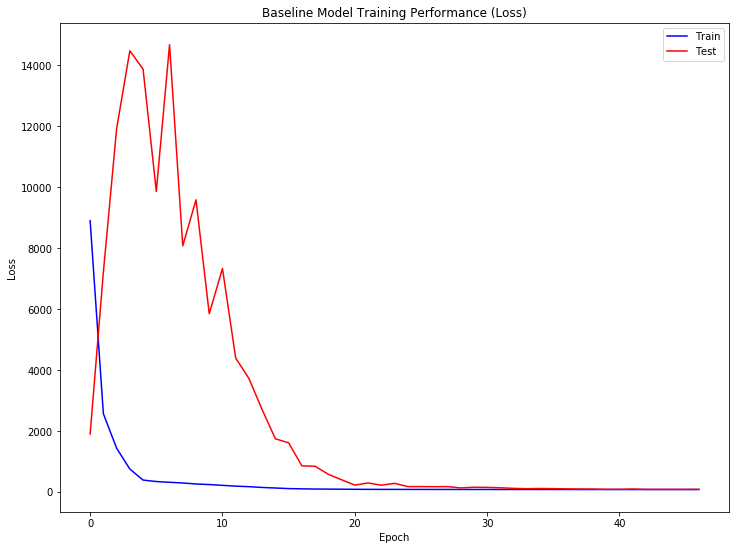

In [0]:
# Define MLP model #4D_3
def create_model_4D_3():
    default_model = Sequential()
    default_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.1))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.1))
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4D_3 = create_model_4D_3()
extra_epochs = 0
baseline_hist = baseline_model_4D_3.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 3
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 36s 79us/sample - loss: 23566.4633 - val_loss: 570.4556
Epoch 2/50
463715/463715 [==============================] - 36s 77us/sample - loss: 2592.1439 - val_loss: 134.4975
Epoch 3/50
463715/463715 [==============================] - 36s 77us/sample - loss: 218.9585 - val_loss: 373.3541
Epoch 4/50
463715/463715 [==============================] - 36s 77us/sample - loss: 114.8667 - val_loss: 94.6339
Epoch 5/50
463715/463715 [==============================] - 36s 77us/sample - loss: 92.8631 - val_loss: 84.5756
Epoch 6/50
463715/463715 [==============================] - 36s 77us/sample - loss: 88.6953 - val_loss: 83.8288
Epoch 7/50
463715/463715 [==============================] - 36s 78us/sample - loss: 87.0446 - val_loss: 82.2889
Epoch 8/50
463715/463715 [==============================] - 36s 77us/sample - loss: 87.5321 - val_loss: 86.9934
Epoch 9/50
463715/463715 [=================

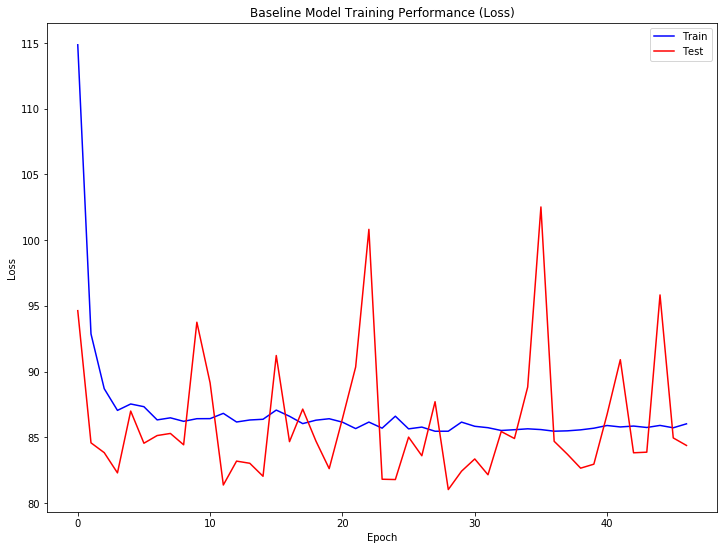

In [0]:
# Define MLP model #4D_4
def create_model_4D_4():
    default_model = Sequential()
    default_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.2))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4D_4 = create_model_4D_4()
extra_epochs = 0
baseline_hist = baseline_model_4D_4.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 3
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 36s 79us/sample - loss: 23566.4633 - val_loss: 570.4556
Epoch 2/50
463715/463715 [==============================] - 36s 77us/sample - loss: 2592.1439 - val_loss: 134.4975
Epoch 3/50
463715/463715 [==============================] - 36s 77us/sample - loss: 218.9585 - val_loss: 373.3541
Epoch 4/50
463715/463715 [==============================] - 36s 77us/sample - loss: 114.8667 - val_loss: 94.6339
Epoch 5/50
463715/463715 [==============================] - 36s 77us/sample - loss: 92.8631 - val_loss: 84.5756
Epoch 6/50
463715/463715 [==============================] - 36s 77us/sample - loss: 88.6953 - val_loss: 83.8288
Epoch 7/50
463715/463715 [==============================] - 36s 78us/sample - loss: 87.0446 - val_loss: 82.2889
Epoch 8/50
463715/463715 [==============================] - 36s 77us/sample - loss: 87.5321 - val_loss: 86.9934
Epoch 9/50
463715/463715 [=================

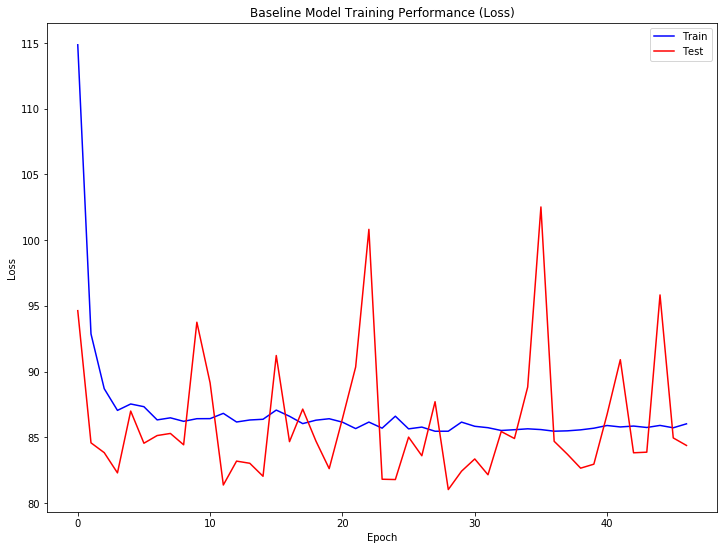

In [0]:
# Define MLP model #4D_5
def create_model_4D_5():
    default_model = Sequential()
    default_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.2))
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4D_5 = create_model_4D_5()
extra_epochs = 0
baseline_hist = baseline_model_4D_5.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 3
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 36s 79us/sample - loss: 23566.4633 - val_loss: 570.4556
Epoch 2/50
463715/463715 [==============================] - 36s 77us/sample - loss: 2592.1439 - val_loss: 134.4975
Epoch 3/50
463715/463715 [==============================] - 36s 77us/sample - loss: 218.9585 - val_loss: 373.3541
Epoch 4/50
463715/463715 [==============================] - 36s 77us/sample - loss: 114.8667 - val_loss: 94.6339
Epoch 5/50
463715/463715 [==============================] - 36s 77us/sample - loss: 92.8631 - val_loss: 84.5756
Epoch 6/50
463715/463715 [==============================] - 36s 77us/sample - loss: 88.6953 - val_loss: 83.8288
Epoch 7/50
463715/463715 [==============================] - 36s 78us/sample - loss: 87.0446 - val_loss: 82.2889
Epoch 8/50
463715/463715 [==============================] - 36s 77us/sample - loss: 87.5321 - val_loss: 86.9934
Epoch 9/50
463715/463715 [=================

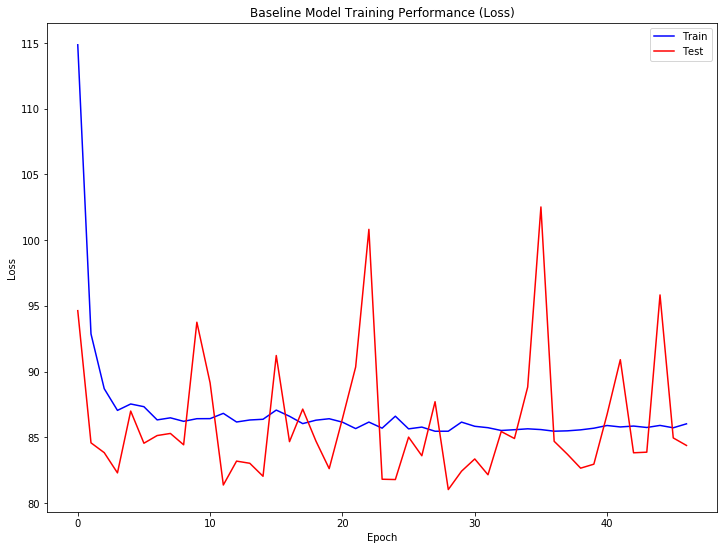

In [0]:
# Define MLP model #4D_6
def create_model_4D_6():
    default_model = Sequential()
    default_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.2))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.2))
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4D_6 = create_model_4D_6()
extra_epochs = 0
baseline_hist = baseline_model_4D_6.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 3
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 56s 121us/sample - loss: 34191.8671 - val_loss: 411.5713
Epoch 2/50
463715/463715 [==============================] - 54s 116us/sample - loss: 2169.6296 - val_loss: 668.9625
Epoch 3/50
463715/463715 [==============================] - 53s 115us/sample - loss: 545.2903 - val_loss: 360.5306
Epoch 4/50
463715/463715 [==============================] - 53s 115us/sample - loss: 195.8489 - val_loss: 95.9354
Epoch 5/50
463715/463715 [==============================] - 54s 116us/sample - loss: 119.3438 - val_loss: 98.9684
Epoch 6/50
463715/463715 [==============================] - 54s 115us/sample - loss: 109.8297 - val_loss: 112.7877
Epoch 7/50
463715/463715 [==============================] - 55s 118us/sample - loss: 101.9337 - val_loss: 131.9972
Epoch 8/50
463715/463715 [==============================] - 54s 116us/sample - loss: 104.5721 - val_loss: 107.8265
Epoch 9/50
463715/463715 [==

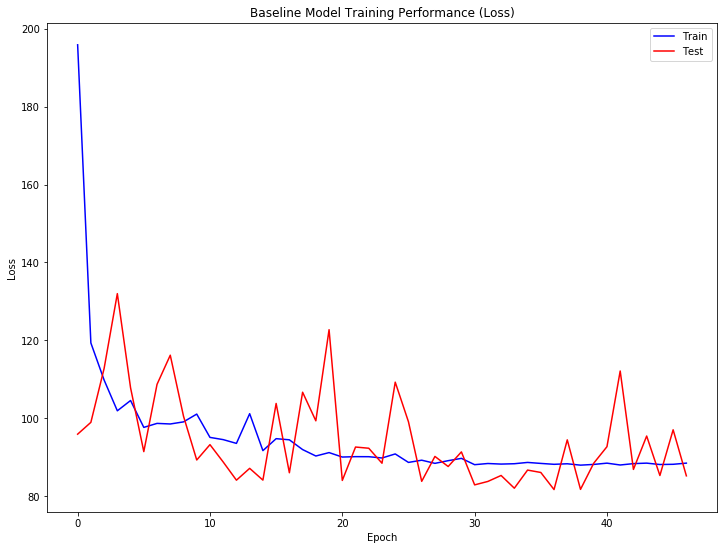

In [36]:
# Define MLP model #4E_1
def create_model_4E_1():
    default_model = Sequential()
    default_model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.1))
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4E_1 = create_model_4E_1()
extra_epochs = 0
baseline_hist = baseline_model_4E_1.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 3
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 54s 115us/sample - loss: 20111.0053 - val_loss: 864.6843
Epoch 2/50
463715/463715 [==============================] - 54s 117us/sample - loss: 3891.7976 - val_loss: 27038.3670
Epoch 3/50
463715/463715 [==============================] - 54s 117us/sample - loss: 1122.9567 - val_loss: 40513.2377
Epoch 4/50
463715/463715 [==============================] - 54s 116us/sample - loss: 796.1528 - val_loss: 43207.2558
Epoch 5/50
463715/463715 [==============================] - 53s 115us/sample - loss: 529.2160 - val_loss: 35907.3692
Epoch 6/50
463715/463715 [==============================] - 53s 115us/sample - loss: 415.1516 - val_loss: 38813.6105
Epoch 7/50
463715/463715 [==============================] - 53s 115us/sample - loss: 385.0226 - val_loss: 37711.2401
Epoch 8/50
463715/463715 [==============================] - 53s 115us/sample - loss: 354.0470 - val_loss: 42528.7026
Epoch 9/50


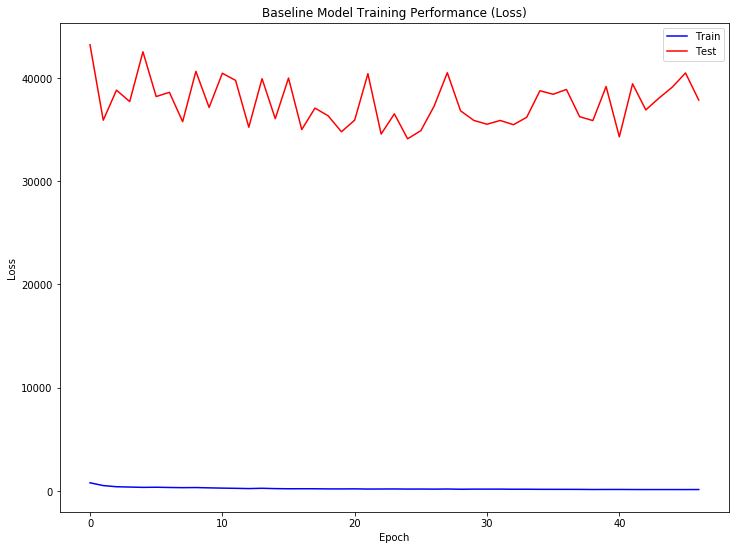

In [37]:
# Define MLP model #4E_2
def create_model_4E_2():
    default_model = Sequential()
    default_model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.1))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4E_2 = create_model_4E_2()
extra_epochs = 0
baseline_hist = baseline_model_4E_2.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 3
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 55s 118us/sample - loss: 23318.2566 - val_loss: 737.2846
Epoch 2/50
463715/463715 [==============================] - 55s 119us/sample - loss: 4656.9977 - val_loss: 40244.0810
Epoch 3/50
463715/463715 [==============================] - 54s 117us/sample - loss: 3004.2804 - val_loss: 32145.6852
Epoch 4/50
463715/463715 [==============================] - 55s 118us/sample - loss: 2746.6456 - val_loss: 50509.6434
Epoch 5/50
463715/463715 [==============================] - 55s 120us/sample - loss: 2358.7435 - val_loss: 24092.1877
Epoch 6/50
463715/463715 [==============================] - 55s 119us/sample - loss: 1347.9088 - val_loss: 32567.4724
Epoch 7/50
463715/463715 [==============================] - 54s 117us/sample - loss: 858.7173 - val_loss: 40904.9989
Epoch 8/50
463715/463715 [==============================] - 54s 117us/sample - loss: 756.6330 - val_loss: 29967.5144
Epoch 9/

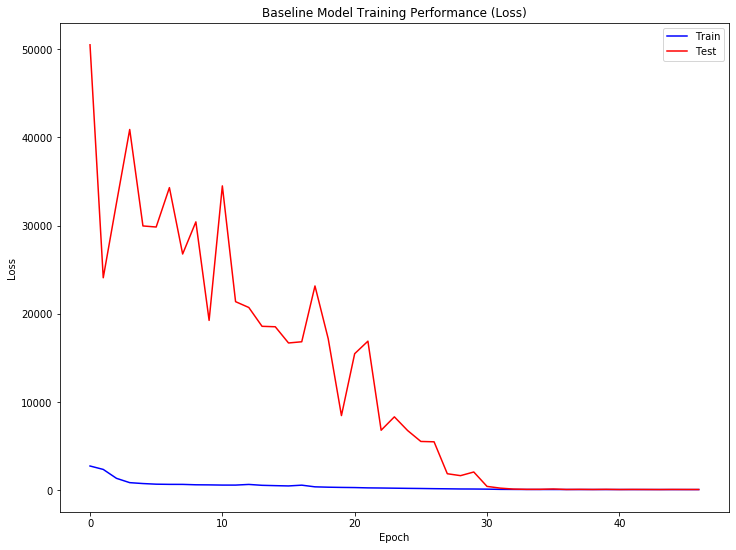

In [38]:
# Define MLP model #4E_3
def create_model_4E_3():
    default_model = Sequential()
    default_model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.1))
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.1))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4E_3 = create_model_4E_3()
extra_epochs = 0
baseline_hist = baseline_model_4E_3.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 3
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 58s 125us/sample - loss: 36066.7826 - val_loss: 1450.5692
Epoch 2/50
463715/463715 [==============================] - 55s 120us/sample - loss: 20941.1124 - val_loss: 2190.2618
Epoch 3/50
463715/463715 [==============================] - 56s 120us/sample - loss: 20261.1393 - val_loss: 1047.3302
Epoch 4/50
463715/463715 [==============================] - 56s 121us/sample - loss: 19725.7308 - val_loss: 1410.8493
Epoch 5/50
463715/463715 [==============================] - 56s 121us/sample - loss: 19095.7161 - val_loss: 806.5860
Epoch 6/50
463715/463715 [==============================] - 56s 120us/sample - loss: 18478.4133 - val_loss: 738.6843
Epoch 7/50
463715/463715 [==============================] - 56s 122us/sample - loss: 17567.7691 - val_loss: 2000.3225
Epoch 8/50
463715/463715 [==============================] - 56s 120us/sample - loss: 16629.3699 - val_loss: 278.0691
Epoch 9/

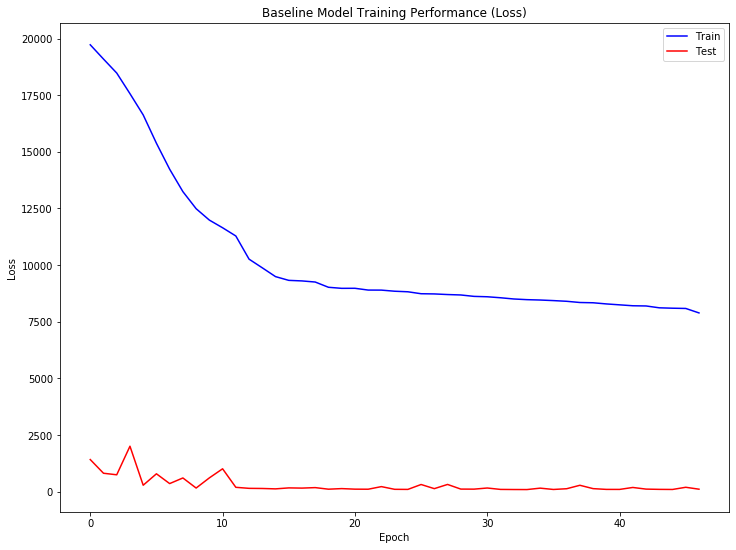

In [39]:
# Define MLP model #4E_4
def create_model_4E_4():
    default_model = Sequential()
    default_model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.1))
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.1))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.1))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4E_4 = create_model_4E_4()
extra_epochs = 0
baseline_hist = baseline_model_4E_4.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 3
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 56s 121us/sample - loss: 38445.0521 - val_loss: 1318.7240
Epoch 2/50
463715/463715 [==============================] - 57s 122us/sample - loss: 21865.4160 - val_loss: 1323.2715
Epoch 3/50
463715/463715 [==============================] - 56s 120us/sample - loss: 20077.4214 - val_loss: 1529.9438
Epoch 4/50
463715/463715 [==============================] - 56s 121us/sample - loss: 18380.5983 - val_loss: 720.2423
Epoch 5/50
463715/463715 [==============================] - 56s 120us/sample - loss: 17064.7509 - val_loss: 911.7837
Epoch 6/50
463715/463715 [==============================] - 56s 120us/sample - loss: 16070.2207 - val_loss: 398.6781
Epoch 7/50
463715/463715 [==============================] - 56s 121us/sample - loss: 15201.0756 - val_loss: 716.9066
Epoch 8/50
463715/463715 [==============================] - 56s 122us/sample - loss: 14552.1422 - val_loss: 365.6570
Epoch 9/50

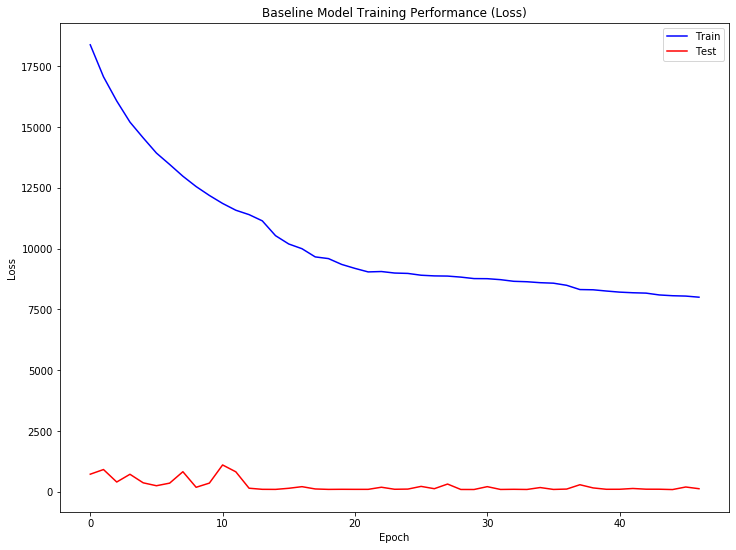

In [40]:
# Define MLP model #4E_5
def create_model_4E_5():
    default_model = Sequential()
    default_model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.2))
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.1))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.1))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4E_5 = create_model_4E_5()
extra_epochs = 0
baseline_hist = baseline_model_4E_5.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 3
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 56s 121us/sample - loss: 32871.2505 - val_loss: 1706.3617
Epoch 2/50
463715/463715 [==============================] - 55s 119us/sample - loss: 10433.3073 - val_loss: 56566.0753
Epoch 3/50
463715/463715 [==============================] - 55s 118us/sample - loss: 4487.7970 - val_loss: 84852.2451
Epoch 4/50
463715/463715 [==============================] - 55s 119us/sample - loss: 1853.9611 - val_loss: 94858.2760
Epoch 5/50
463715/463715 [==============================] - 55s 118us/sample - loss: 1485.9364 - val_loss: 93757.8110
Epoch 6/50
463715/463715 [==============================] - 55s 118us/sample - loss: 1427.8353 - val_loss: 82627.6030
Epoch 7/50
463715/463715 [==============================] - 55s 118us/sample - loss: 1394.6932 - val_loss: 104278.7605
Epoch 8/50
463715/463715 [==============================] - 55s 119us/sample - loss: 1350.7325 - val_loss: 109598.3830
Ep

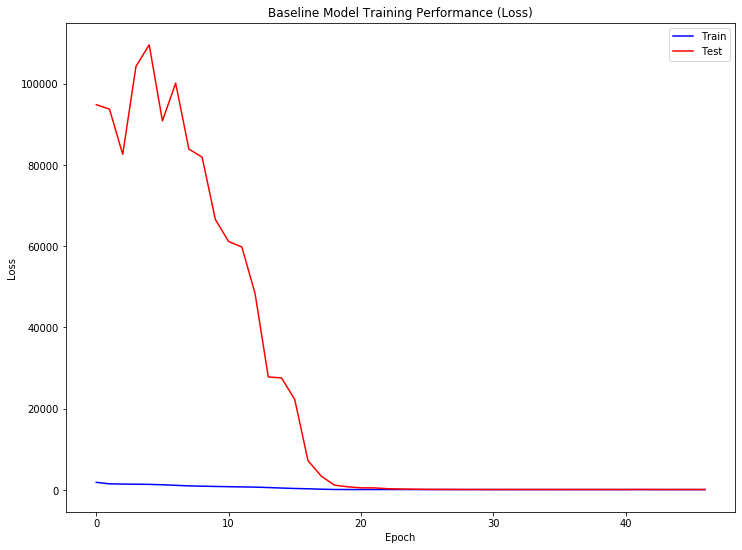

In [41]:
# Define MLP model #4E_6
def create_model_4E_6():
    default_model = Sequential()
    default_model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.2))
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.2))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4E_6 = create_model_4E_6()
extra_epochs = 0
baseline_hist = baseline_model_4E_6.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 3
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 56s 122us/sample - loss: 45212.0120 - val_loss: 1393.4975
Epoch 2/50
463715/463715 [==============================] - 57s 123us/sample - loss: 28179.8892 - val_loss: 3403.1183
Epoch 3/50
463715/463715 [==============================] - 57s 122us/sample - loss: 26058.6158 - val_loss: 1421.9767
Epoch 4/50
463715/463715 [==============================] - 56s 122us/sample - loss: 23535.6714 - val_loss: 2066.7178
Epoch 5/50
463715/463715 [==============================] - 56s 121us/sample - loss: 20519.9489 - val_loss: 622.2249
Epoch 6/50
463715/463715 [==============================] - 56s 121us/sample - loss: 17153.6971 - val_loss: 371.4753
Epoch 7/50
463715/463715 [==============================] - 56s 121us/sample - loss: 13866.1119 - val_loss: 734.3605
Epoch 8/50
463715/463715 [==============================] - 56s 120us/sample - loss: 12189.1476 - val_loss: 137.9932
Epoch 9/5

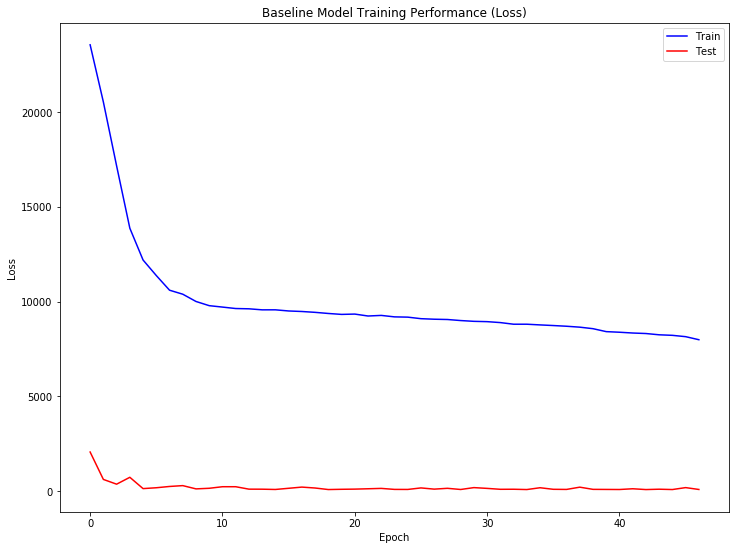

In [42]:
# Define MLP model #4E_7
def create_model_4E_7():
    default_model = Sequential()
    default_model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.2))
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.2))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.1))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4E_7 = create_model_4E_7()
extra_epochs = 0
baseline_hist = baseline_model_4E_7.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 3
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 57s 123us/sample - loss: 60569.4964 - val_loss: 1701.4352
Epoch 2/50
463715/463715 [==============================] - 57s 123us/sample - loss: 43224.3141 - val_loss: 5006.5328
Epoch 3/50
463715/463715 [==============================] - 57s 124us/sample - loss: 41354.7647 - val_loss: 1962.2095
Epoch 4/50
463715/463715 [==============================] - 57s 122us/sample - loss: 39759.8109 - val_loss: 1657.1011
Epoch 5/50
463715/463715 [==============================] - 56s 122us/sample - loss: 37297.6361 - val_loss: 1072.1038
Epoch 6/50
463715/463715 [==============================] - 57s 122us/sample - loss: 34920.0106 - val_loss: 1011.2247
Epoch 7/50
463715/463715 [==============================] - 57s 122us/sample - loss: 31920.5728 - val_loss: 1511.3582
Epoch 8/50
463715/463715 [==============================] - 57s 123us/sample - loss: 29297.0185 - val_loss: 816.4364
Epoch 

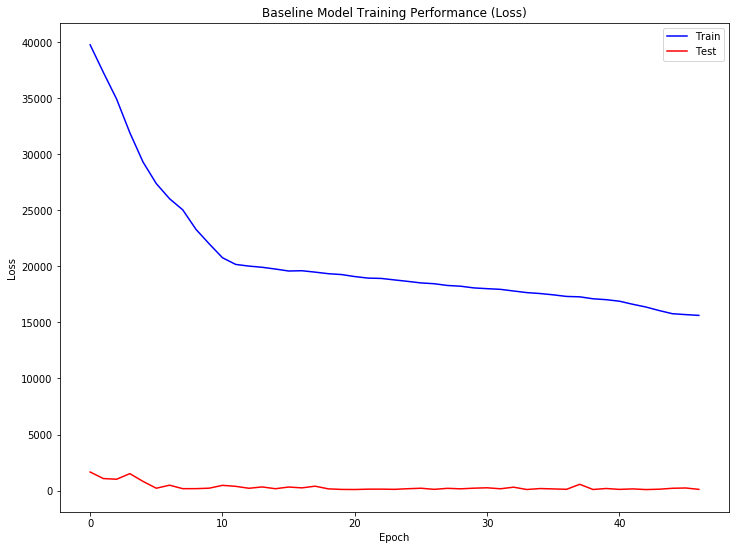

In [43]:
# Define MLP model #4E_8
def create_model_4E_8():
    default_model = Sequential()
    default_model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.2))
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.2))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.2))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4E_8 = create_model_4E_8()
extra_epochs = 0
baseline_hist = baseline_model_4E_8.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 3
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 56s 120us/sample - loss: 43729.9685 - val_loss: 12689.9890
Epoch 2/50
463715/463715 [==============================] - 57s 122us/sample - loss: 13243.2605 - val_loss: 124193.0106
Epoch 3/50
463715/463715 [==============================] - 56s 121us/sample - loss: 6346.9986 - val_loss: 168849.9335
Epoch 4/50
463715/463715 [==============================] - 55s 119us/sample - loss: 2724.5460 - val_loss: 229349.6888
Epoch 5/50
463715/463715 [==============================] - 55s 119us/sample - loss: 2036.5405 - val_loss: 181917.5226
Epoch 6/50
463715/463715 [==============================] - 55s 119us/sample - loss: 1807.5121 - val_loss: 171076.5575
Epoch 7/50
463715/463715 [==============================] - 55s 119us/sample - loss: 1591.7813 - val_loss: 147904.7061
Epoch 8/50
463715/463715 [==============================] - 56s 121us/sample - loss: 1452.1859 - val_loss: 121674.3

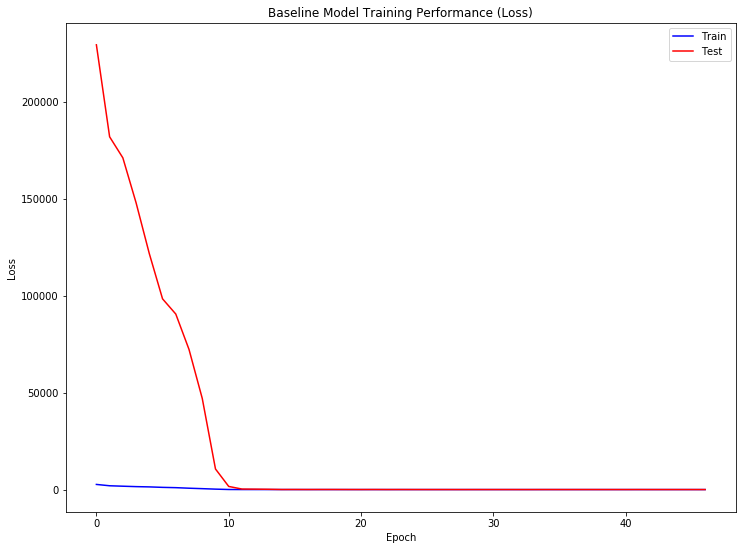

In [44]:
# Define MLP model #4E_9
def create_model_4E_9():
    default_model = Sequential()
    default_model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.3))
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.3))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4E_9 = create_model_4E_9()
extra_epochs = 0
baseline_hist = baseline_model_4E_9.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 3
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [0]:
if (notifyStatus): email_notify("Phase 4 Explore Different One-Layer Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 5. Finalize Model

In [0]:
if (notifyStatus): email_notify("Phase 5 Finalize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [47]:
# Display a summary of the final model
final_model = baseline_model_4E_6
print(final_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               23296     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 64,513
Trainable params: 64,513
Non-trainable params: 0
__________________________________________________

In [48]:
# Display the configuration of the final model
print(final_model.get_config())

{'name': 'sequential_2', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense_8', 'trainable': True, 'batch_input_shape': (None, 90), 'dtype': 'float32', 'units': 256, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotNormal', 'config': {'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dropout', 'config': {'name': 'dropout_2', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'noise_shape': None, 'seed': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_9', 'trainable': True, 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotNormal', 'config': {'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer'

In [0]:
if (notifyStatus): email_notify("Phase 5 Finalize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [50]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 6:55:04.023576
